In [1]:
!pip install ray[tune]

Defaulting to user installation because normal site-packages is not writeable


DEPRECATION: Loading egg at d:\anaconda\lib\site-packages\fonttools-4.51.0-py3.11-win-amd64.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330
DEPRECATION: Loading egg at d:\anaconda\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from  PIL import Image
import torch
from torch import nn
from torchvision import transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR
from sklearn.model_selection import KFold
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import ray
from ray import tune
from ray.tune.schedulers import AsyncHyperBandScheduler
import warnings

warnings.filterwarnings("ignore")

torch.manual_seed(2697134)

### Explanation of WatermarkDataset Class
This class is used to load and process a dataset of watermarked images. The dataset loads images from the root directory using the paths specified in a CSV file, resizes the images to the specified size, and applies optional transformations. It returns the length of the dataset and images at a given index, taking into account the subsampling rate. This class ensures compatibility with data loaders for use in model training and validation phases.


In [3]:
class WatermarkDataset(Dataset):
    """
    @param csv_file_path: Path to the CSV file containing paths to the images.
    @param database_root_dir: Root directory where the images are stored.
    @param image_size: Tuple of integers (width, height) representing the size to which each image is resized.
    @param subsample: Integer specifying how many items to skip over; 1 means every item is used, 2 means every second item, etc.
    @param transform: Optional callable that will be applied to each image (for data augmentation, normalization, etc.).
    """
    def __init__(self, csv_file_path, database_root_dir, image_size, subsample, transform = None):
        # Load the CSV file containing paths to the images.
        self.csvFile = pd.read_csv(csv_file_path)
        # Set the root directory where images are stored.
        self.database_root_dir = database_root_dir
        # Set the size to which images should be resized.
        self.image_size = image_size
        # Set the subsampling rate (to downsample the dataset for quicker iterations).
        self.subsample = subsample
        # Optional transformation to be applied on each image.
        self.transform = transform

    def __len__(self):
        # Return the length of the dataset accounting for subsampling.
        return len(self.csvFile) // self.subsample

    def __getitem__(self, id):
        # Compute the actual index of the image by considering the subsampling rate.
        actual_id = id * self.subsample

        # Create the full path for watermarked(input) and clear(target) images.
        input_image_path = os.path.join(self.database_root_dir, self.csvFile.iloc[actual_id, 1])
        target_image_path = os.path.join(self.database_root_dir, self.csvFile.iloc[actual_id, 0])

        # Open images, convert to RGB, and resize both input and target images.
        input_image = Image.open(input_image_path).convert('RGB').resize((self.image_size, self.image_size))
        target_image = Image.open(target_image_path).convert('RGB').resize((self.image_size, self.image_size))

        # Apply transformations if any are specified.
        if self.transform:
            input_image = self.transform(input_image)
            target_image = self.transform(target_image)

        # Return the processed images as a tuple.
        return input_image, target_image

### Explanation of DoubleConv, Down, Up, OutConv, and UNet Classes

These classes form the basic components of the U-Net architecture, which is used for removing watermarks from images. Each class's function is explained below:

**DoubleConv Class**:
This class is a module consisting of two consecutive convolutional layers. The first layer applies convolution using the number of channels from the input and then applies Batch Normalization and ReLU activation function. The same process is repeated for the second convolutional layer. This module extracts features from the image and enriches the feature map.

**Down Class**:
This class is a downscaling module that combines max pooling with a double convolution. First, the max pooling layer halves the input size, and then the double convolutional layer extracts features. This module reduces the size of the input image while preserving important features.

**Up Class**:
This class is an upscaling module that combines a transpose convolution with a double convolution. The transpose convolution layer doubles the input size, and then the double convolutional layer extracts features. This module reconstructs higher resolution feature maps and concatenates them with features from previous layers.

**OutConv Class**:
This class is the final convolutional layer that maps the features to the desired number of classes. This layer converts the output feature map to the final image.

**UNet Class**:
This class uses the U-Net architecture to remove watermarks from images. U-Net is an encoder-decoder structure that reduces the input image to various feature levels and then reconstructs these features at higher resolution. This structure ensures that important features are preserved at each stage and produces high-quality output images. The model takes input images and processes them through double convolution, downscaling, and upscaling modules, ultimately providing watermark-free output images.


In [4]:
class DoubleConv(nn.Module):
    """
    A module consisting of two consecutive convolutional layers.
    """
    def __init__(self, in_channels, out_channels):
        """
        @param in_channels Number of channels in the input.
        @param out_channels Number of channels in the output of the second convolution.
        @param mid_channels Optional; Number of channels in the output of the first convolution and input of the second.
        """
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        """
        Forward pass of the DoubleConv module.

        @param x: Tensor.
        """
        return self.double_conv(x)

class Down(nn.Module):
    """
    A downscaling module combining max pooling with a double convolution.
    """
    def __init__(self, in_channels, out_channels):
        """
        @param in_channels: Number of input channels.
        @param out_channels: Number of output channels for the double convolution.
        """
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        """
        Forward pass of the Down module.

        @param x: Tensor.
        """
        return self.maxpool_conv(x)

class Up(nn.Module):
    """
    An upscaling module combining a transpose convolution with a double convolution.
    """
    def __init__(self, in_channels, out_channels):
        """
        @param in_channels: Number of input channels.
        @param out_channels: Number of output channels for the double convolution.
        @param bilinear Boolean; Use bilinear upsampling instead of transposed convolution if True.
        """
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        """
        Forward pass of the Up module.

        @param x1: Tensor; Output from the lower layer.
        @param x2: Tensor; Corresponding encoder feature for concatenation.
        """
        x1 = self.up(x1)
        
        # Calculate the difference in height and width between the tensors x2 and x1
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        
        # Pad x1 to match the size of x2
        # F.pad(x1, [left, right, top, bottom]) pads the input tensor x1
        # so that its size matches x2's size in height and width dimensions.
        # This ensures that x1 and x2 can be concatenated along the channel dimension.
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    """
    The final convolution that maps the features to the desired number of classes.
    """
    def __init__(self, in_channels, out_channels):
        """
        @param in_channels: Number of input channels.
        @param out_channels: Number of output channels.
        """
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        """
        Forward pass of the OutConv module.

        @param x: Tensor.
        """
        return self.conv(x)
    
class UNet(nn.Module):
    """
    U-Net architecture to remove watermarks from images.
    """
    def __init__(self, n_channels=3, n_classes=3):
        """
        @param n_channels: Number of channels in the input images.
        @param n_classes: Number of channels in the output images.
        """
        super(UNet, self).__init__()

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        self.down4 = (Down(512, 1024))
        self.up1 = (Up(1024, 512))
        self.up2 = (Up(512, 256))
        self.up3 = (Up(256, 128))
        self.up4 = (Up(128, 64))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        """
        Forward pass of the entire U-Net model.

        @param x Tensor; Input image or batch of images.
        """
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

### Explanation of WeightedMSELoss Class

This class defines a custom loss function that applies a weighted mean squared error (MSE) loss to emphasize the watermark regions in images. The `__init__` method initializes the `WeightedMSELoss` class with a `watermark_weight` parameter, which specifies the additional weight to apply to the watermark regions. The `forward` method calculates the weighted MSE loss between the model's output and the target images, emphasizing the regions identified as watermarks. It takes as input the watermarked images, the output images from the model, and the ground truth clear images, and returns the computed weighted MSE loss. This method computes a mask for the watermark regions using the threshold method, calculates the squared differences between the model's output and the target images, weights these differences according to the mask, and returns the mean of the weighted squared differences. The `watermarkMask` method generates a binary mask that identifies regions where the input and target images differ significantly, assumed to be watermark regions. It takes the watermarked and clear images as input and uses a threshold to decide whether a difference is significant enough to be considered part of a watermark, returning a binary mask of the watermark regions.

In [5]:
class WeightedMSELoss(nn.Module):
    """
    A custom loss function that applies a weighted mean squared error loss to require more focus on the watermarks.
    """
    def __init__(self, watermark_weight=10.0):
        """
        @param watermark_weight: Float that specifies the additional weight to apply to the watermark regions.
        """
        super(WeightedMSELoss, self).__init__()
        self.watermark_weight = watermark_weight

    def forward(self, input_images, model_output_images, target_images):
        """
        Calculates the weighted MSE loss between the model output and the target images, emphasizing
        the regions identified as watermarks.

        @param input_images Tensor; the watermarked images to the model.
        @param model_output_images Tensor; the output images from the model.
        @param target_images Tensor; the ground truth clear images.
        @return Tensor; the computed weighted MSE loss.
        """
        # Compute a mask for the watermark regions using the threshold method.
        weights = torch.ones_like(target_images) + self.watermarkMask(input_images, target_images) * (self.watermark_weight - 1)
        squared_diff = (model_output_images - target_images) ** 2
        weighted_squared_diff = squared_diff * weights
        loss = weighted_squared_diff.mean()
        return loss

    def watermarkMask(self, input_images, target_images, threshold=0.05):
        """
        Generates a binary mask that identifies regions where the input and target images differ
        significantly, assumed to be watermark regions.

        @param input_images Tensor; the watermarked images.
        @param target_images Tensor; the clear images.
        @param threshold Float; the threshold used to decide whether a difference is significant enough to be considered part of a watermark.
        @return Tensor; a binary mask of the watermark regions.
        """
        diff = torch.abs(input_images - target_images)
        mask = (diff > threshold).float()
        return mask

### Explanation of trainModelWithHyperband Function

This function trains a model using the given configuration and the Hyperband scheduler. It begins by initializing the model and moving it to the specified device (e.g., CPU or GPU). The optimizer (Adam) is set up with the specified learning rate, and the learning rate scheduler is configured with the specified step size and gamma. The watermark weight tensor is initialized and moved to the specified device, and the loss function is defined with the watermark weight. The dataset is retrieved from the configuration, and it is split into training and validation sets (80% training, 20% validation). Data loaders are created for both training and validation sets. The training loop iterates over the specified number of epochs. During each epoch, the model is set to training mode, and batch losses are initialized. For each batch of training data, the gradients are zeroed, input and target images are moved to the specified device, the model output is obtained, the loss is calculated, backpropagation is performed, and model parameters are updated. The batch loss is stored. After processing all batches, the scheduler is stepped, and the average training loss for the epoch is calculated and reported using `ray.train.report`.

In [6]:
def trainModelWithHyperband(config, checkpoint_dir=None):
    # Initialize the model and move it to the specified device (e.g., CPU or GPU)
    model = config["model"]
    model.to(config["device"])

    # Set up the optimizer (Adam) with the specified learning rate
    optim = torch.optim.Adam(model.parameters(), lr=config["lr"])

    # Set up the learning rate scheduler with the specified step size and gamma
    scheduler = StepLR(optim, step_size=config["step_size"], gamma=config["gamma"])

    # Initialize the watermark weight tensor and move it to the specified device
    watermark_weight = torch.tensor(10.0, device=config["device"])

    # Define the loss function with the watermark weight
    loss_func = WeightedMSELoss(watermark_weight=watermark_weight)

    # Get the dataset from the config
    dataset = config["dataset"]

    # Split the dataset into training and validation sets (80% train, 20% validation)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    # Create data loaders for training and validation sets
    training_loader = DataLoader(train_dataset, batch_size=int(config["batch_size"]), shuffle=True)
    validation_loader = DataLoader(val_dataset, batch_size=int(config["batch_size"]), shuffle=False)

    # Training loop
    for epoch in range(config["n_epochs"]):
        model.train()  # Set the model to training mode
        batch_losses = []  # List to store batch losses

        # Iterate over batches of training data
        for input_image, target_image in training_loader:
            optim.zero_grad()  # Zero the gradients before backward pass
            input_images = input_image.to(config["device"])  # Move input images to the specified device
            target_images = target_image.to(config["device"])  # Move target images to the specified device
            model_output_images = model(input_images)  # Get model output
            loss_outputs = loss_func(input_images, model_output_images, target_images)  # Calculate loss
            loss_outputs.backward()  # Perform backpropagation
            optim.step()  # Update model parameters
            batch_losses.append(loss_outputs.item())  # Store batch loss
        
        # Step the scheduler
        scheduler.step()

        # Calculate and report the average training loss for the epoch
        average_train_loss = np.mean(batch_losses)
        ray.train.report({'loss': average_train_loss})

### Explanation of validateModel Function

This function validates the model on the validation dataset and computes the average loss, PSNR, and SSIM. The watermark weight tensor is initialized and moved to the specified device, and the loss function is defined with the watermark weight. The model is set to evaluation mode, and gradient computation is disabled for validation using `torch.no_grad()`. Validation losses, PSNR values, and SSIM values are stored in lists. For each batch of validation data, input and target images are moved to the specified device, and the model output is obtained. The loss is calculated and stored. The model output and target images are converted to numpy arrays for PSNR and SSIM calculation. For each image in the batch, PSNR and SSIM values are calculated and stored. The appropriate `win_size` for SSIM calculation is determined based on the dimensions of the images. Finally, the average validation loss, PSNR, and SSIM are calculated and printed. The function returns the average validation loss.

In [7]:
def validateModel(model, validationLoader, device):
    # Initialize the watermark weight tensor and move it to the specified device
    watermark_weight = torch.tensor(10.0, device=device)
    
    # Define the loss function with the watermark weight
    loss = WeightedMSELoss(watermark_weight=watermark_weight)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for validation
    with torch.no_grad():
        val_losses = []  # List to store validation losses
        psnrs = []  # List to store PSNR values
        ssims = []  # List to store SSIM values
        
        # Iterate over batches of validation data
        for input_images, target_images in validationLoader:
            input_images = input_images.to(device)  # Move input images to the specified device
            target_images = target_images.to(device)  # Move target images to the specified device
            model_output_images = model(input_images)  # Get model output
            
            # Calculate the loss
            output_loss = loss(input_images, model_output_images, target_images)
            val_losses.append(output_loss.item())  # Store the loss
            
            # Convert the model output and target images to numpy arrays for PSNR and SSIM calculation
            model_output_images_np = model_output_images.cpu().numpy()
            target_images_np = target_images.cpu().numpy()

            # Calculate PSNR and SSIM for each image in the batch
            for i in range(model_output_images_np.shape[0]):
                cur_psnr = psnr(target_images_np[i], model_output_images_np[i])
                
                # Determine the appropriate win_size for SSIM calculation
                min_side = min(target_images_np[i].shape[:2])  # Assume the first two dimensions are spatial dimensions
                if min_side < 7:
                    win_size = min_side  # If smaller than 7, use the actual size
                else:
                    win_size = 7  # Default recommended win_size
                
                cur_ssim = ssim(
                    target_images_np[i], 
                    model_output_images_np[i], 
                    win_size=win_size, 
                    data_range=target_images_np[i].max() - target_images_np[i].min(), 
                    multichannel=True
                )
                
                psnrs.append(cur_psnr)  # Store the PSNR value
                ssims.append(cur_ssim)  # Store the SSIM value
                
        # Calculate the average validation loss, PSNR, and SSIM
        validation_loss = np.mean(val_losses)
        avg_psnr = np.mean(psnrs)
        avg_ssim = np.mean(ssims)

        # Print the validation metrics
        print(f"\t\tValidation Loss: {validation_loss}")
        print(f"\t\tValidation Average PSNR: {avg_psnr}")
        print(f"\t\tValidation Average SSIM: {avg_ssim}")

        return validation_loss

In [8]:
def formatLossGraph(x, pos):
    # Formatter function to format the loss values for the graph
    return f'{x * 1e3:.1f}'

### Explanation of trainModel Function

This function trains a model using the specified dataset, optimizer, and training configuration, and performs K-fold cross-validation. It begins by printing the device being used (e.g., CPU or GPU). The watermark weight tensor is initialized and moved to the specified device, and the loss function is defined with the watermark weight. K-fold cross-validation is set up with the specified number of folds, and the learning rate scheduler is configured with the specified step size and gamma. Lists are initialized to store training and validation losses.

For each fold in the K-fold split, the function prints the current fold number and initializes lists to store training and validation losses for the current fold. Data loaders for training and validation sets are created using the fold-specific indices. The training loop iterates over the specified number of epochs. During each epoch, the model is set to training mode, and batch losses are initialized. For each batch of training data, the gradients are zeroed, input and target images are moved to the specified device, the model output is obtained, the loss is calculated, backpropagation is performed, and model parameters are updated. The batch loss is stored. After processing all batches, the scheduler is stepped, and the average training loss for the epoch is calculated and printed.

The model is then validated using the `validateModel` function, and the validation loss is stored. The overall training and validation losses are extended with the losses from the current fold. After training and validation for all folds, the trained model state is saved to a file. Finally, the training and validation losses are plotted using Matplotlib.

In [9]:
def trainModel(model, optim, dataset, watermark_weight, n_epochs, mini_batch_size, num_folds, step_size, gamma, device, model_save_name):
    # Print the device being used (e.g., CPU or GPU)
    print(device)

    # Formatter for the loss graph
    formatter = FuncFormatter(formatLossGraph)
    
    # Initialize the watermark weight tensor and move it to the specified device
    watermark_weight = torch.tensor(watermark_weight, device=device)
    
    # Define the loss function with the watermark weight
    loss_func = WeightedMSELoss(watermark_weight=watermark_weight)
    
    # Set up K-fold cross-validation with the specified number of folds
    k_fold = KFold(n_splits=num_folds, shuffle=True, random_state=2697134)
    
    # Set up the learning rate scheduler with the specified step size and gamma
    scheduler = StepLR(optim, step_size, gamma)
    
    # Lists to store training and validation losses
    training_losses = []
    val_losses = []

    # Iterate over each fold
    for fold, (train_ids, val_ids) in enumerate(k_fold.split(dataset)):
        print(f'{model_save_name} Fold {fold+1}')

        fold_training_losses = []  # List to store training losses for the current fold
        fold_val_losses = []  # List to store validation losses for the current fold
        
        # Create data loaders for training and validation sets
        train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
        val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)
        
        training_loader = DataLoader(dataset, batch_size=mini_batch_size, sampler=train_subsampler, num_workers=0, pin_memory=True)
        validation_loader = DataLoader(dataset, batch_size=mini_batch_size, sampler=val_subsampler, num_workers=0, pin_memory=True)

        # Training loop for each epoch
        for epoch in range(n_epochs):
            model.train()  # Set the model to training mode
            batch_losses = []  # List to store batch losses

            # Iterate over batches of training data
            for input_image, target_image in training_loader:
                optim.zero_grad()  # Zero the gradients before backward pass
                input_images = input_image.to(device)  # Move input images to the specified device
                target_images = target_image.to(device)  # Move target images to the specified device
                model_output_images = model(input_images)  # Get model output
                loss_outputs = loss_func(input_images, model_output_images, target_images)  # Calculate loss
                loss_outputs.backward()  # Perform backpropagation
                optim.step()  # Update model parameters
                
                batch_losses.append(loss_outputs.item())  # Store batch loss

            scheduler.step()  # Step the scheduler

            # Calculate and print the average training loss for the epoch
            epoch_loss = np.mean(batch_losses)
            fold_training_losses.append(epoch_loss)
            print(f"\tEpoch {epoch + 1}")
            print(f"\t\tTraining Loss: {fold_training_losses[epoch]}")

            # Validate the model and store the validation loss
            fold_val_losses.append(validateModel(model, validation_loader, device))

        # Extend the overall training and validation losses with the losses from the current fold
        training_losses.extend(fold_training_losses)
        val_losses.extend(fold_val_losses)

    # Save the trained model state
    torch.save(model.state_dict(), f"{model_save_name}.pt")
        
    # Plot the training and validation losses
    plt.figure(figsize=(10, 5))
    plt.title(f'{model_save_name} Final Graphic')
    plt.plot(range(1, len(training_losses) + 1), training_losses, label='Final Training Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Final Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (x1e-3)')
    plt.title(f'Fold {fold+1} Training and Validation Losses')
    plt.gca().yaxis.set_major_formatter(formatter)
    plt.legend()
    plt.show(block=False)

### Explanation of testModel Function

This function tests a model using the specified test dataset, transformation, and training configuration. It begins by creating the test dataset from the metadata CSV file and the root directory. A data loader for the test dataset is then created. The watermark weight tensor is initialized and moved to the specified device, and the loss function is defined with the watermark weight. The model is set to evaluation mode, and gradient computation is disabled for testing using `torch.no_grad()`.

Lists are initialized to store test losses, PSNR values, and SSIM values. For each batch of test data, input and target images are moved to the specified device, and the model output is obtained. The loss is calculated and stored. The model output and target images are converted to numpy arrays for PSNR and SSIM calculation. For each image in the batch, PSNR and SSIM values are calculated and stored. The appropriate `win_size` for SSIM calculation is determined based on the dimensions of the images.

Finally, the average test loss, PSNR, and SSIM are calculated and printed. The function prints the average test loss, average PSNR, and average SSIM values to summarize the model's performance on the test dataset.

In [10]:
def testModel(model, test_path, transform, mini_batch_size, device, model_save_name):
    # Create the test dataset
    dataset = WatermarkDataset(f"{test_path}/metadata.csv", test_path, image_size, 1, transform)
    
    # Create a data loader for the test dataset
    datasetLoader = DataLoader(dataset, batch_size=mini_batch_size, shuffle=True)
    
    # Initialize the watermark weight tensor and move it to the specified device
    watermark_weight = torch.tensor(10.0, device=device)
    
    # Define the loss function with the watermark weight
    loss = WeightedMSELoss(watermark_weight=watermark_weight)
    
    # Set the model to evaluation mode
    model.eval()
    
    # Disable gradient computation for testing
    with torch.no_grad():
        test_losses = []  # List to store test losses
        psnrs = []  # List to store PSNR values
        ssims = []  # List to store SSIM values
        
        # Iterate over batches of test data
        for input_images, target_images in datasetLoader:
            input_images = input_images.to(device)  # Move input images to the specified device
            target_images = target_images.to(device)  # Move target images to the specified device
            model_output_images = model(input_images)  # Get model output
            
            # Calculate the loss
            output_loss = loss(input_images, model_output_images, target_images)
            test_losses.append(output_loss.item())  # Store the loss
            
            # Convert the model output and target images to numpy arrays for PSNR and SSIM calculation
            model_output_images_np = model_output_images.cpu().numpy()
            target_images_np = target_images.cpu().numpy()

            # Calculate PSNR and SSIM for each image in the batch
            for i in range(model_output_images_np.shape[0]):
                cur_psnr = psnr(target_images_np[i], model_output_images_np[i])
                
                # Determine the appropriate win_size for SSIM calculation
                min_side = min(target_images_np[i].shape[:2])  # Assume the first two dimensions are spatial dimensions
                if min_side < 7:
                    win_size = min_side  # If smaller than 7, use the actual size
                else:
                    win_size = 7  # Default recommended win_size
                
                cur_ssim = ssim(
                    target_images_np[i], 
                    model_output_images_np[i], 
                    win_size=win_size, 
                    data_range=target_images_np[i].max() - target_images_np[i].min(), 
                    multichannel=True
                )
                
                psnrs.append(cur_psnr)  # Store the PSNR value
                ssims.append(cur_ssim)  # Store the SSIM value
                
        # Calculate the average test loss, PSNR, and SSIM
        test_loss = np.mean(test_losses)
        avg_psnr = np.mean(psnrs)
        avg_ssim = np.mean(ssims)

        # Print the test results
        print(f"{model_save_name} Test Results")
        print(f"\tAverage Test Loss: {test_loss}")
        print(f"\tAverage PSNR: {avg_psnr}")
        print(f"\tAverage SSIM: {avg_ssim}")

### Explanation of zeroMeanNormalize Function
This function normalizes the input tensor by subtracting the mean value from each element. This is used to preprocess the images before starting the model training.

In [11]:
def zeroMeanNormalize(tensor):
    # Calculate the mean of the tensor along the specified dimensions
    mean = tensor.mean([1, 2], keepdim=True)
    # Subtract the mean from the tensor to normalize it
    return tensor - mean

### Explanation of initModelWeights Function

This function initializes the weights of convolutional layers in the model using Xavier uniform initialization. If the layer has a bias term, it initializes the bias to zero. The Xavier uniform initialization helps in achieving faster and more stable convergence during the training of deep learning models.

In [12]:
def initModelWeights(m):
    # Initialize the weights of convolutional layers using Xavier uniform initialization
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        # If the layer has a bias term, initialize it to zero
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)

### Explanation of startHyperparameterTuning Function

This function starts the hyperparameter tuning process using Ray Tune. It begins by creating the training dataset from the metadata CSV file and the root directory. The model is initialized and moved to the specified device, and the weight initialization function is applied to the model. A custom trial name creator function is defined for the hyperparameter tuning trials.

Ray is initialized for distributed hyperparameter tuning. The Hyperband scheduler is set up with specific parameters for hyperparameter tuning, including the maximum training time, grace period, reduction factor, metric, and mode.

Ray Tune is run with the specified configuration, including the model, dataset, image size, device, and hyperparameter search spaces for learning rate, batch size, step size, gamma, and number of epochs. The number of hyperparameter trials is set to 30, and the scheduler and verbosity level are specified. The custom trial name creator function is used to create custom trial names.

The best trial is obtained based on the validation loss, and the best hyperparameter configuration is printed. Ray is shut down to release resources, and the model is deleted to free up memory. The function returns the best hyperparameter configuration.

In [13]:
def startHyperparameterTuning(transform, initModelWeights, train_path, image_size, device):
    # Create the training dataset
    dataset = WatermarkDataset(f"{train_path}/metadata.csv", train_path, image_size, 20, transform)
    
    # Initialize the model and move it to the specified device
    model = UNet().to(device)  
    
    # Apply the weight initialization function to the model
    model.apply(initModelWeights)   
    
    # Define a custom trial name creator function for the hyperparameter tuning trials
    def customTrialNameCreator(trial):
        return f"trial_{trial.trial_id}_{trial.config['lr']}_{trial.config['batch_size']}"
        
    # Initialize Ray for distributed hyperparameter tuning
    ray.init()
    
    # Set up the hyperband scheduler for hyperparameter tuning
    scheduler = AsyncHyperBandScheduler(
        time_attr="training_iteration",
        max_t=50,
        grace_period=5,
        reduction_factor=3,
        metric="loss",
        mode="min")
    
    # Run the hyperparameter tuning with Ray Tune
    analysis = tune.run(
        trainModelWithHyperband,
        resources_per_trial={"cpu": 8, "gpu": 1},  # Resources allocated per trial
        config={
            "model": model,
            "dataset": dataset,
            "image_size": image_size,
            "device": device,
            "lr": tune.loguniform(1e-4, 1),  # Learning rate search space
            "batch_size": tune.choice([16, 32, 64]),  # Batch size search space
            "step_size": tune.choice([5, 10, 15]),  # Step size search space
            "gamma": tune.choice([0.1, 0.5, 0.9]),  # Gamma search space
            "n_epochs": tune.choice([30, 40, 50])  # Number of epochs search space
        },
        num_samples=30,  # Number of hyperparameter trials
        scheduler=scheduler,  # Scheduler for hyperparameter tuning
        verbose=2,  # Verbosity level
        name="train_model_hyperband",  # Name of the tuning experiment
        trial_dirname_creator=customTrialNameCreator  # Function to create custom trial names
    )
    
    # Get the best trial based on the validation loss
    best_trial = analysis.get_best_trial("loss", "min", "last")
    print("Best trial config: {}".format(best_trial.config))
    print("Best trial final validation loss: {}".format(best_trial.last_result["loss"]))

    # Extract the best hyperparameter configuration
    best_config = best_trial.config
    
    # Shut down Ray to release resources
    ray.shutdown()
    
    # Delete the model to free up memory
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # Clear CUDA cache if using GPU

    return best_config  # Return the best hyperparameter configuration

### Explanation of startTraining Function

This function starts the training process for a model using the best hyperparameter configuration obtained from the hyperparameter tuning. It extracts the best hyperparameter values from the configuration, including batch size, learning rate, number of epochs, step size, and gamma.

The training dataset is created from the metadata CSV file and the root directory. The model is initialized and moved to the specified device, and the weight initialization function is applied to the model. The optimizer is set up with the specified learning rate.

The model is trained using the specified parameters and dataset. The `trainModel` function is called with the model, optimizer, dataset, watermark weight, number of epochs, mini-batch size, number of folds, step size, gamma, device, and model save name.

After training, the model is tested using the specified test dataset and transformation. The `testModel` function is called with the model, test path, transformation, mini-batch size, device, and model save name.

Finally, the model is deleted to free up memory, and if using a GPU, the CUDA cache is cleared to release resources.

In [14]:
def startTraining(best_config, transform, initModelWeights, watermark_weight, image_size, num_folds, train_path, test_path, device, model_save_name):
    # Extract the best hyperparameter configuration
    mini_batch_size = best_config["batch_size"]
    learning_rate = best_config["lr"]
    n_epochs = best_config["n_epochs"] // num_folds  # Divide epochs by the number of folds
    step_size = best_config["step_size"]
    gamma = best_config["gamma"]
    
    # Create the training dataset
    dataset = WatermarkDataset(f"{train_path}/metadata.csv", train_path, image_size, 1, transform) 
    
    # Initialize the model and move it to the specified device
    model = UNet().to(device)  
    
    # Apply the weight initialization function to the model
    model.apply(initModelWeights)                  
          
    # Set up the optimizer with the specified learning rate
    optim = torch.optim.Adam(model.parameters(), learning_rate) 
    
    # Train the model using the specified parameters and dataset
    trainModel(model, optim, dataset, watermark_weight, n_epochs, mini_batch_size, num_folds, step_size, gamma, device, model_save_name)
    
    # Test the model using the specified test dataset and transformation
    testModel(model, test_path, transform, mini_batch_size, device, model_save_name)
    
    # Delete the model to free up memory
    del model
    if torch.cuda.is_available():
        torch.cuda.empty_cache()  # Clear CUDA cache if using GPU

### Definitions
Below code block sets up the device and training configuration for the model.

First, it checks if CUDA is available. If a GPU is available, it prints the GPU name; otherwise, it prints a message indicating that no GPU is found. Based on the availability of CUDA, it sets the device to CUDA if available, otherwise to CPU.

The image size for the dataset is defined as 128, and the watermark weight is set to 10. The number of folds for cross-validation is specified as 5. 

A transformation is defined to be applied to the images, which includes converting the images to tensors and normalizing them using the `zeroMeanNormalize` function.

In [15]:
# Check if CUDA is available and print the GPU name if available, otherwise print a message indicating no GPU found
if torch.cuda.is_available():
    print(torch.cuda.get_device_name(0))
else:   
    print("no GPU found")

# Set the device to CUDA if available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the image size for the dataset
image_size = 128

# Define the watermark weight
watermark_weight = 10

# Define the number of folds for cross-validation
num_folds = 5 

# Define the transformation to be applied to the images, including normalization
transform = transforms.Compose([
    transforms.ToTensor(),
    zeroMeanNormalize
])

NVIDIA GeForce RTX 3070 Ti Laptop GPU


### No Logo And Low Opacity Model Hyperparameter Optimization, Training And Test
Below block creates No Logo And Low Opacity U-Net Model

First, The paths for the training and test datasets are defined using the current working directory and the specified folder names.

After then, The hyperparameter tuning process is started using the defined configurations by calling the `startHyperparameterTuning` function with the transformation, weight initialization function, training path, image size, and device.

Finally, hyperparameter tuning process, model training, validation and test process using startTraining function with best config parameters from hyperband is started

### ***IMPORTANT NOTE***
Raytune has shown many warnings regarding performance bottleneck during hyperparameter optimization. Although many methods were tried to close these error messages, they were not successful.

NVIDIA GeForce RTX 3070 Ti Laptop GPU


2024-05-23 02:40:10,482	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-23 02:40:11,916	INFO tune.py:614 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,loss
trainModelWithHyperband_a1bd4_00000,0.00098895
trainModelWithHyperband_a1bd4_00001,0.0342007
trainModelWithHyperband_a1bd4_00002,0.000903311
trainModelWithHyperband_a1bd4_00003,0.0170163
trainModelWithHyperband_a1bd4_00004,0.000579875
trainModelWithHyperband_a1bd4_00005,0.00481761
trainModelWithHyperband_a1bd4_00006,0.000645144
trainModelWithHyperband_a1bd4_00007,0.000991633
trainModelWithHyperband_a1bd4_00008,0.00379399
trainModelWithHyperband_a1bd4_00009,0.00236317


2024-05-23 02:45:28,539	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 44.333 s, which may be a performance bottleneck.
2024-05-23 02:45:28,539	WARNING util.py:201 -- The `process_trial_result` operation took 44.333 s, which may be a performance bottleneck.
2024-05-23 02:45:28,539	WARNING util.py:201 -- Processing trial results took 44.333 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-23 02:45:28,555	WARNING util.py:201 -- The `process_trial_result` operation took 44.348 s, which may be a performance bottleneck.
2024-05-23 02:48:40,656	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 48.975 s, which may be a performance bottleneck.
2024-05-23 02:48:40,667	WARNING util.py:201 -- The `process_trial_result` operation took 48.986 s, which may be a performance bottleneck.
2024-05-23 02:48:40,668	WARNING util.py:201 -- Processing trial results took 48.987 s, which may be a performan

Best trial config: {'model': UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

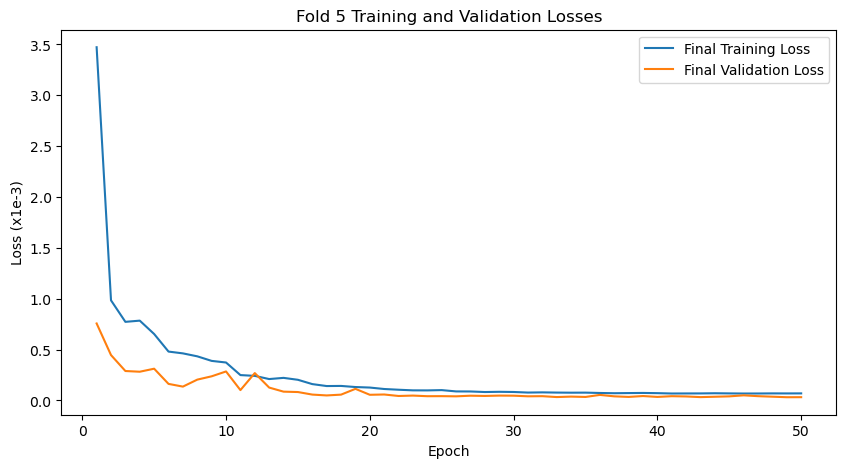

modelNoLogoLOpacity Test Results
	Average Test Loss: 3.169995306961937e-05
	Average PSNR: 54.96872464043579
	Average SSIM: 0.9901973127689295


In [15]:
# Define the paths for the training and test datasets
train_path = os.getcwd() + "/no_logo_and_low_opacity_watermark_dataset_train"
test_path = os.getcwd() + "/no_logo_and_low_opacity_watermark_dataset_test"

# Start the hyperparameter tuning process using the defined configurations
best_config = startHyperparameterTuning(transform, initModelWeights, train_path, image_size, device)
# Start the training, validation and test process using the best configurations from hyperband
startTraining(best_config, transform, initModelWeights, watermark_weight, image_size, num_folds, train_path, test_path, device, "modelNoLogoLOpacity")

### No Logo And High Opacity Model Hyperparameter Optimization, Training And Test
Below block creates No Logo And High Opacity U-Net Model

2024-05-26 22:28:21,666	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-26 22:28:23,158	INFO tune.py:614 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,loss
trainModelWithHyperband_1dde6_00000,0.00257964
trainModelWithHyperband_1dde6_00001,0.00109567
trainModelWithHyperband_1dde6_00002,0.00115267
trainModelWithHyperband_1dde6_00003,0.00371806
trainModelWithHyperband_1dde6_00004,0.000943432
trainModelWithHyperband_1dde6_00005,0.00206287
trainModelWithHyperband_1dde6_00006,0.0353389
trainModelWithHyperband_1dde6_00007,0.00301182
trainModelWithHyperband_1dde6_00008,0.0359329
trainModelWithHyperband_1dde6_00009,0.0359494


2024-05-26 22:33:47,071	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 45.201 s, which may be a performance bottleneck.
2024-05-26 22:33:47,071	WARNING util.py:201 -- The `process_trial_result` operation took 45.201 s, which may be a performance bottleneck.
2024-05-26 22:33:47,071	WARNING util.py:201 -- Processing trial results took 45.201 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-26 22:33:47,071	WARNING util.py:201 -- The `process_trial_result` operation took 45.201 s, which may be a performance bottleneck.
2024-05-26 22:36:53,581	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 44.004 s, which may be a performance bottleneck.
2024-05-26 22:36:53,596	WARNING util.py:201 -- The `process_trial_result` operation took 44.019 s, which may be a performance bottleneck.
2024-05-26 22:36:53,596	WARNING util.py:201 -- Processing trial results took 44.019 s, which may be a performan

Best trial config: {'model': UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

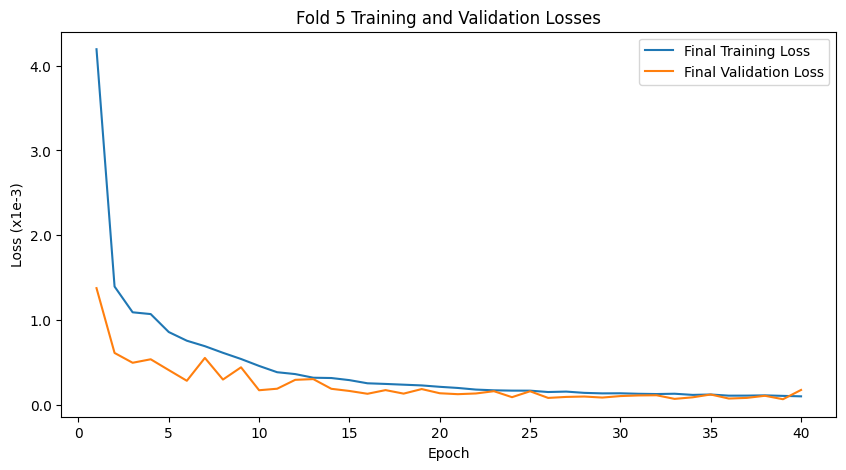

modelNoLogoHOpacity Test Results
	Average Test Loss: 0.00015139468893884885
	Average PSNR: 46.90792103210165
	Average SSIM: 0.9702861880244207


In [15]:
train_path = os.getcwd() + "/no_logo_and_high_opacity_watermark_dataset_train"
test_path = os.getcwd() + "/no_logo_and_high_opacity_watermark_dataset_test"

best_config = startHyperparameterTuning(transform, initModelWeights, train_path, image_size, device)
startTraining(best_config, transform, initModelWeights, watermark_weight, image_size, num_folds, train_path, test_path, device, "modelNoLogoHOpacity")

### Logo And High Opacity Model Hyperparameter Optimization, Training And Test
Below block creates Logo And High Opacity U-Net Model

2024-05-29 00:09:57,125	INFO worker.py:1749 -- Started a local Ray instance.
2024-05-29 00:09:59,114	INFO tune.py:614 -- [output] This uses the legacy output and progress reporter, as Jupyter notebooks are not supported by the new engine, yet. For more information, please see https://github.com/ray-project/ray/issues/36949


Trial name,loss
trainModelWithHyperband_a42b1_00000,0.0357627
trainModelWithHyperband_a42b1_00001,0.00167945
trainModelWithHyperband_a42b1_00002,0.0357266
trainModelWithHyperband_a42b1_00003,0.00130436
trainModelWithHyperband_a42b1_00004,0.035331
trainModelWithHyperband_a42b1_00005,0.00124606
trainModelWithHyperband_a42b1_00006,0.00256138
trainModelWithHyperband_a42b1_00007,0.00279489
trainModelWithHyperband_a42b1_00008,0.00515529
trainModelWithHyperband_a42b1_00009,0.0014554


2024-05-29 00:15:14,458	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 43.336 s, which may be a performance bottleneck.
2024-05-29 00:15:14,460	WARNING util.py:201 -- The `process_trial_result` operation took 43.338 s, which may be a performance bottleneck.
2024-05-29 00:15:14,460	WARNING util.py:201 -- Processing trial results took 43.338 s, which may be a performance bottleneck. Please consider reporting results less frequently to Ray Tune.
2024-05-29 00:15:14,461	WARNING util.py:201 -- The `process_trial_result` operation took 43.340 s, which may be a performance bottleneck.
2024-05-29 00:18:19,697	WARNING util.py:201 -- The `callbacks.on_trial_result` operation took 44.653 s, which may be a performance bottleneck.
2024-05-29 00:18:19,700	WARNING util.py:201 -- The `process_trial_result` operation took 44.656 s, which may be a performance bottleneck.
2024-05-29 00:18:19,700	WARNING util.py:201 -- Processing trial results took 44.656 s, which may be a performan

Best trial config: {'model': UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), 

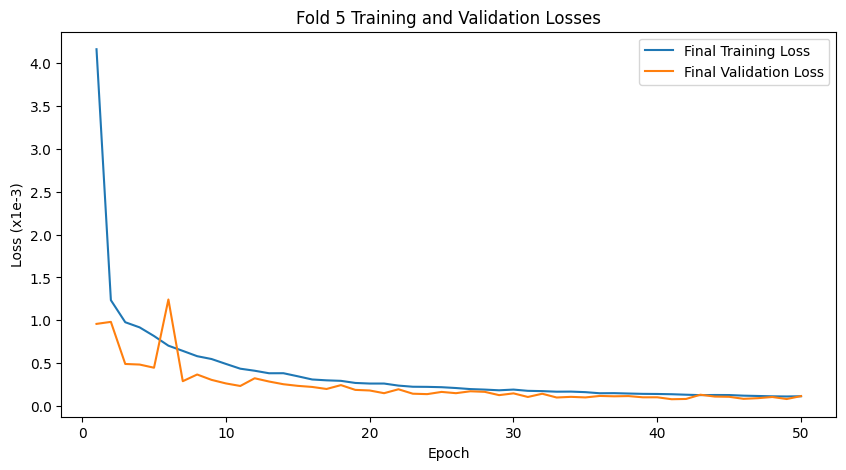

modelLogoHOpacity Test Results
	Average Test Loss: 0.00014737646051798947
	Average PSNR: 49.51239989339584
	Average SSIM: 0.9670536850707767


In [16]:
train_path = os.getcwd() + "/logo_and_high_opacity_watermark_dataset_train"
test_path = os.getcwd() + "/logo_and_high_opacity_watermark_dataset_test"

best_config = startHyperparameterTuning(transform, initModelWeights, train_path, image_size, device)
startTraining(best_config, transform, initModelWeights, watermark_weight, image_size, num_folds, train_path, test_path, device, "modelLogoHOpacity")